In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# define cmaps for viruses
hsv1_palette_r = sns.light_palette((168/256, 97/256, 92/256), reverse=False, as_cmap=True)
hcmv_palette_r = sns.light_palette((71/256, 103/256, 133/256), reverse=False, as_cmap=True)
kshv_palette_r = sns.light_palette((113/256, 175/256, 71/256), reverse=False, as_cmap=True)

pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load data

In [9]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

In [3]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]

In [26]:
folder = r'..\Skyline_reports'
replicate_fmt = 'treatment_timepoint_replicate'
index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name']
data_cols = ['Total Area Fragment', 'Peptide Retention Time']

hsv1_filename = 'HSV-1_baseline.csv'
hsv1 = load_herpesvirusPRMreport(os.path.join(folder, hsv1_filename), 'HSV-1', data_cols=data_cols, index_cols=index_cols).where(lambda x: x!=0, np.nan).reset_index()
hsv1['virus'] = 'HSV-1'
hsv1= hsv1.set_index(['virus']+index_cols).squeeze() 

hcmv_filename = 'HCMV_baseline.csv'
hcmv = load_herpesvirusPRMreport(os.path.join(folder, hcmv_filename), 'HCMV', data_cols=data_cols, index_cols=index_cols).where(lambda x: x!=0, np.nan).reset_index()
hcmv['virus'] = 'HCMV'
hcmv= hcmv.set_index(['virus']+index_cols).squeeze() 

kshv_filename = 'KSHV_baseline.csv'
kshv = load_herpesvirusPRMreport(os.path.join(folder, kshv_filename), 'KSHV', data_cols=data_cols, index_cols=index_cols).where(lambda x: x!=0, np.nan).reset_index()
kshv['virus'] = 'KSHV'
kshv = kshv.set_index(['virus']+index_cols).squeeze()

baseline = pd.concat([hsv1, hcmv, kshv])
baseline = baseline[~baseline.index.duplicated()]
filename_mapping = baseline.reset_index()[['virus', 'treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

hsv1_ext = pd.concat([load_herpesvirusPRMreport(os.path.join(folder, 'HSV-1_DMSO_ACV_3uM.csv'), 'HSV-1', data_cols = data_cols, index_cols = index_cols), hsv1.reset_index('virus', drop=True)], keys = ['HSV-1 DMSO', 'HSV-1 WT'], names = ['virus'])['Total Area Fragment']
hsv1_ext = hsv1_ext.unstack('treatment')[['DMSO', 'WT']].stack().reset_index().set_index(hsv1.index.names).squeeze()
baseline_ext = pd.concat([hsv1_ext, hcmv, kshv])
filename_mapping_ext = baseline_ext.reset_index()[['virus', 'treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates
Duplicate entries detected, dropping duplicates


# Normalize Data

### MS1 normalization

In [33]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(baseline.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['virus', 'treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['virus', 'treatment', 'replicate']).apply(lambda x: x/x.mean())
baseline_adj = baseline['Total Area Fragment'].groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)

MS1_ext = pd.read_csv(filename, index_col=[0]).squeeze()
MS1_ext.index = MS1_ext.index+'.raw'
MS1_ext = pd.concat([MS1_ext[MS1_ext.index.isin(baseline_ext.index.get_level_values('File Name').unique())], filename_mapping_ext], axis=1).reset_index().set_index(['virus', 'treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios_ext = MS1_ext.groupby(['virus', 'treatment', 'replicate']).apply(lambda x: x/x.mean())
baseline_adj_ext = baseline_ext.groupby(ratios.index.names).apply(lambda x: x/ratios_ext[x.name]).unstack('File Name').mean(axis=1)


### Mean Normalization

In [ ]:
cols = ['timepoint']
baseline_norm = mean_normalize(baseline_adj.unstack(cols)).stack(cols)
baseline_avg = baseline_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
baseline_mean = baseline_avg.unstack(['replicate', 'treatment']).mean(axis=1)

baseline_norm_ext = mean_normalize(baseline_adj_ext.unstack(cols)).stack(cols)
baseline_avg_ext = baseline_norm_ext.unstack(['Peptide Modified Sequence']).mean(axis=1)
baseline_mean_ext = baseline_avg_ext.unstack(['replicate', 'treatment']).mean(axis=1)

# Make Figures

### Fig. 1C

In [13]:
print(tableS1.groupby(['virus', 'temporal class']).size())
print('========================================')
print(tableS1.groupby(['virus', 'virion classification*']).size())

virus  temporal class
HSV-1  E                 16
       IE                 5
       L                 38
       host               6
       normalization      2
HCMV   DE                41
       IE                 7
       L                 27
       LL                15
       host               1
       normalization      2
KSHV   DE                27
       IE                 6
       L                 29
       normalization      1
dtype: int64
virus  virion classification*
HSV-1  capsid                     8
       envelope                  11
       non-structural            17
       tegument                  23
HCMV   capsid                     7
       envelope                  11
       non-structural            38
       tegument                  34
KSHV   capsid                     7
       envelope                   8
       non-structural            24
       tegument                  23
dtype: int64


### Fig. 1D

In [40]:
# compute number of concurrent precursors
conc = {}
n=100
arr = np.linspace(10, 80, n)

for w in [3, 6, 10, 15]:
    conc[w] = []
    for i, x in enumerate(arr):
        start = x-w/2
        end = x+w/2
        conc[w].append(baseline['Peptide Retention Time'].groupby(['virus', 'treatment', 'timepoint', 'replicate']).apply(lambda y: ((y>=start)&(y<=end)).sum()))
        
        if i%(n/10)==0:
            print(int(x), end='   ')
    conc[w] = pd.concat(conc[w], keys = arr, names = ['RT'])
conc = pd.concat(conc, names =['window'])

10   17   24   31   38   45   52   59   66   73   10   17   24   31   38   45   52   59   66   73   10   17   24   31   38   45   52   59   66   73   10   17   24   31   38   45   52   59   66   73   

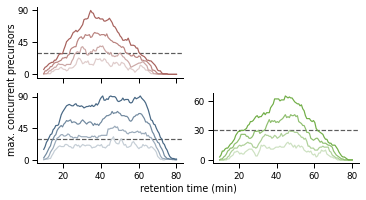

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (5.03, 2.7), sharex=True,)
axs.flatten()[1].remove()
for ax, v in zip([axs.flatten()[0]]+axs.flatten()[2:].tolist(), ['HSV-1', 'HCMV', 'KSHV']):
    data = conc.unstack(['virus', 'window', 'RT']).max().sort_index().loc[v]
    sns.lineplot(data=data.reset_index(), x='RT', y=0, 
                 hue = 'window',
                 palette = dict(zip(['HSV-1', 'HCMV', 'KSHV'], [hsv1_palette_r(np.linspace(0, 1, 5)[1:]).tolist(), hcmv_palette_r (np.linspace(0, 1, 5)[1:]).tolist(), kshv_palette_r(np.linspace(0, 1, 5)[1:]).tolist()]))[v], 
                 ax=ax,)
    
    ax.axhline(30, ls='--', c=pal[-1], zorder=-1)
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_yticks(np.linspace(0, int(np.round(ax.get_ylim()[1])/10)*10, 3))
    
fig.text(0.5, 0, 'retention time (min)', ha='center')
fig.text(0, 0.52, 'max. concurrent precursors', va='center', rotation='vertical')


fig.tight_layout()
fig.savefig(r'..\figures\Fig1D.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 1E

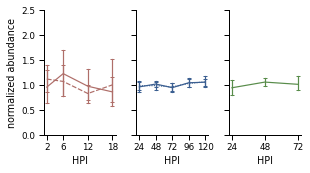

In [36]:
fig, axs = plt.subplots(figsize=(4.4, 2.5), ncols=3, sharey=True, sharex='col')

xticks = dict(zip(['HCMV', 'KSHV', 'HSV-1 WT', 'HSV-1 DMSO'], [[24, 48, 72, 96, 120], [24, 48, 72], [2, 6, 12, 18], [2, 6, 12, 18]]))

for v, ax, c in zip(['HSV-1', 'HCMV', 'KSHV'], axs, bright_pal):
    
    data=baseline_norm_ext[(baseline_norm_ext.index.get_level_values('temporality')=='normalization')&(baseline_norm_ext.index.get_level_values('virus').str.contains(v))]
    sns.lineplot(data=data.reset_index(), x='timepoint', y=0, 
                 ax=ax, 
                 err_style='bars', 
                 color=c, 
                 err_kws={'capsize':2}, 
                 style='Protein Gene',
                 style_order = ['TUBA1A', 'MYH9', 'MYO5A']
                )

    ax.set_xticks(xticks[data.reset_index()['virus'].unique()[0]])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 2.5)
    ax.set_xlabel('HPI')
   
    
    ax.get_legend().remove()

axs[0].set_ylabel('normalized abundance')
fig.tight_layout()
fig.savefig(r'..\figures\Fig1E.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 1F

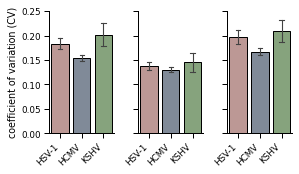

In [38]:
l = [['Peptide Modified Sequence'], 
     ['replicate'],
     ['replicate', 'Peptide Modified Sequence']
    ]

fig, axs = plt.subplots(ncols = len(l), figsize = (4.25, 2.5), sharey=True)

for ax, i in zip(axs, l):
    
    data = baseline_norm.unstack(i).groupby('virus', group_keys=False).apply(compute_CV)
    sns.barplot(data=data.reset_index(), x='virus', y=0, 
                hue='virus', ax=ax, dodge=False, 
                hue_order = ['HSV-1', 'HCMV', 'KSHV'], 
                order = ['HSV-1', 'HCMV', 'KSHV'], 
                capsize=0.2, 
                errwidth=1.1, 
                saturation=0.75,
               )
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('')
    ax.get_legend().remove()
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 0.25)
    
    for p in ax.patches:
        r, g, b, a = p.get_facecolor()
        p.set_facecolor((r, g, b, 0.75))
        p.set_edgecolor('k')
        p.set_linewidth(1)
    
    
axs[0].set_ylabel('coefficient of variation (CV)')
fig.tight_layout()
fig.savefig(r'..\figures\Fig1F.png', dpi=1000, bbox_inches='tight')
plt.show()